In [1]:
import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)
import tslearn
import dtaidistance

In [2]:
class DataTable: pass
complete_series = joblib.load('prepared_data/all_data_filled_na.jbl')
dtw_km = joblib.load('algorithms/dtw_km.alg')
if not os.path.exists("images/apply/"):
    os.makedirs("images/apply/")

In [3]:
def prepare_tslearn_dataset(all_table):
    all_table.matrix = copy.deepcopy(all_table.matrix).dropna(axis=0, how='any')
    info = np.unique(all_table.matrix.CONTRACT_ID, return_counts=True)
    contracts = info[0]
    amounts = info[1]

    relevant = list()
    for contract_id, amount in zip(contracts, amounts):
        if amount >= 12:
            relevant.append(contract_id)
    matrix = all_table.matrix
    long_enough = matrix[matrix['CONTRACT_ID'].isin(relevant)]
    long_enough = long_enough[long_enough['PERIOD_ID'] <= 12]
    series_to_cluster = long_enough[['CONTRACT_ID', 'PERCENT_ACTUAL']]
    X_train = np.zeros(shape=(len(relevant), 12, 1), dtype=np.float32)
    index = 0
    contracts = list()
    for contract_id, df in series_to_cluster.groupby('CONTRACT_ID'):
        contracts.append(contract_id)
        series = df['PERCENT_ACTUAL']
        X_train[index, :, 0] = series
        index += 1
    return X_train, contracts



In [4]:
X_tslearn, contracts = prepare_tslearn_dataset(complete_series)
clusters = dtw_km.predict(X_tslearn)
info = np.unique(clusters, return_counts=True)
for idx, count in zip(info[0], info[1]):
    print("Cluster:", idx + 1, "Size:", count)

Cluster: 1 Size: 3450
Cluster: 2 Size: 161
Cluster: 3 Size: 36
Cluster: 4 Size: 141


/home/nekrald/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


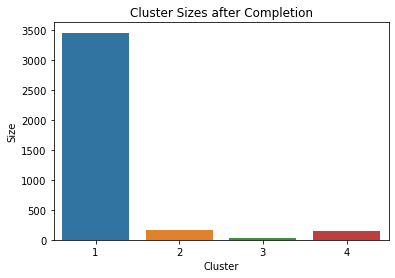

In [5]:
result_df = pd.DataFrame()
result_df['Cluster'] = info[0] + 1
result_df['Size'] = info[1]
sns.barplot('Cluster', 'Size', data=result_df)
plt.title("Cluster Sizes after Completion")
plt.savefig("images/apply/cluster_sizes_dtw.png")